In [1]:
import pandas as pd
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from textblob import TextBlob
from transformers import pipeline
from nltk.tokenize import sent_tokenize
from scripts.sentiment_analysis import *
import math
from scipy import stats
from collections import defaultdict

In [ ]:
all_movies_df = pd.read_csv('all_movies.csv')
all_movies_df = all_movies_df.dropna(subset=['MovieBoxOffice', 'MoviePlot']).reset_index(drop=True)
all_movies_df

In [ ]:
adapted_movies_df = pd.read_csv('adapted_movies.csv')
adapted_movies_df = adapted_movies_df.dropna(subset=['MovieBoxOffice', 'MoviePlot']).reset_index(drop=True)
adapted_movies_df

### sentiment analysis

In [ ]:
algorithms = [vader_sentiment_analysis, textblob_sentiment_analysis, BERT_sentiment_analysis]
sentiments_adapted = sentiment_analysis(adapted_movies_df, algorithms)
sentiments_adapted.to_csv('adapted_movies_sentiments.csv', index=False)
sentiments_adapted

In [ ]:
sentiments_all = sentiment_analysis(all_movies_df, algorithms)
sentiments_all.to_csv('all_movies_sentiments.csv', index=False)
sentiments_all

In [ ]:
adapted_movies_df = pd.read_csv('adapted_movies.csv')
adapted_movies_df = adapted_movies_df.dropna(subset=['BookDescription']).reset_index(drop=True)

algorithms = [vader_sentiment_analysis, textblob_sentiment_analysis, BERT_sentiment_analysis]
sentiment_book = sentiment_analysis(adapted_movies_df, algorithms, 'BookDescription')
sentiment_book.to_csv('adapted_books_sentiments.csv', index=False)
sentiment_book

### correlation between book and movie plot

In [8]:
movie_sentiments = pd.read_csv('adapted_movies_sentiments.csv')
book_sentiments = pd.read_csv('adapted_books_sentiments.csv')

In [ ]:
movie_sentiments

In [ ]:
sentiments = movie_sentiments.merge(book_sentiments, on='wikipedia_id', how='inner', suffixes=('_movie', '_book'))
sentiments

In [32]:
correlations = defaultdict(float)
metrics = [ 'compound', 'neg', 'neu', 'pos', 'polarity', 'subjectivity' , 'sadness', 'joy', 'love', 'anger', 'surprise', 'fear' ]
for metric in metrics:
    pearson_corr, pearson_pval = stats.pearsonr(sentiments[metric + "_book"],sentiments[metric + "_movie"])
    spearman_corr, spearman_pval = stats.spearmanr(sentiments[metric + "_book"],sentiments[metric + "_movie"])
    correlations[metric] = { 'pearson_correlation': pearson_corr,
                            'pearson_pval': pearson_pval,
                            'spearman_correlation': spearman_corr,
                            'spearman_pval': spearman_pval}
correlations = pd.DataFrame(correlations).T


In [33]:
correlations

,pearson_correlation,pearson_pval,spearman_correlation,spearman_pval
compound,0.258787,4.131332e-05,0.298513,1.960190e-06
neg,0.326173,1.762005e-07,0.317920,3.709767e-07
neu,0.188660,3.031111e-03,0.205208,1.237747e-03
pos,0.250243,7.492433e-05,0.243133,1.210390e-04
polarity,0.067432,2.931340e-01,0.111599,8.127898e-02
subjectivity,0.042274,5.101544e-01,0.049393,4.415108e-01
sadness,0.119381,6.207860e-02,0.146411,2.188576e-02
joy,0.139826,2.865599e-02,0.147467,2.094027e-02
love,0.027217,6.716239e-01,0.054519,3.955322e-01
anger,0.157965,1.330646e-02,0.149057,1.958333e-02


### data exploration

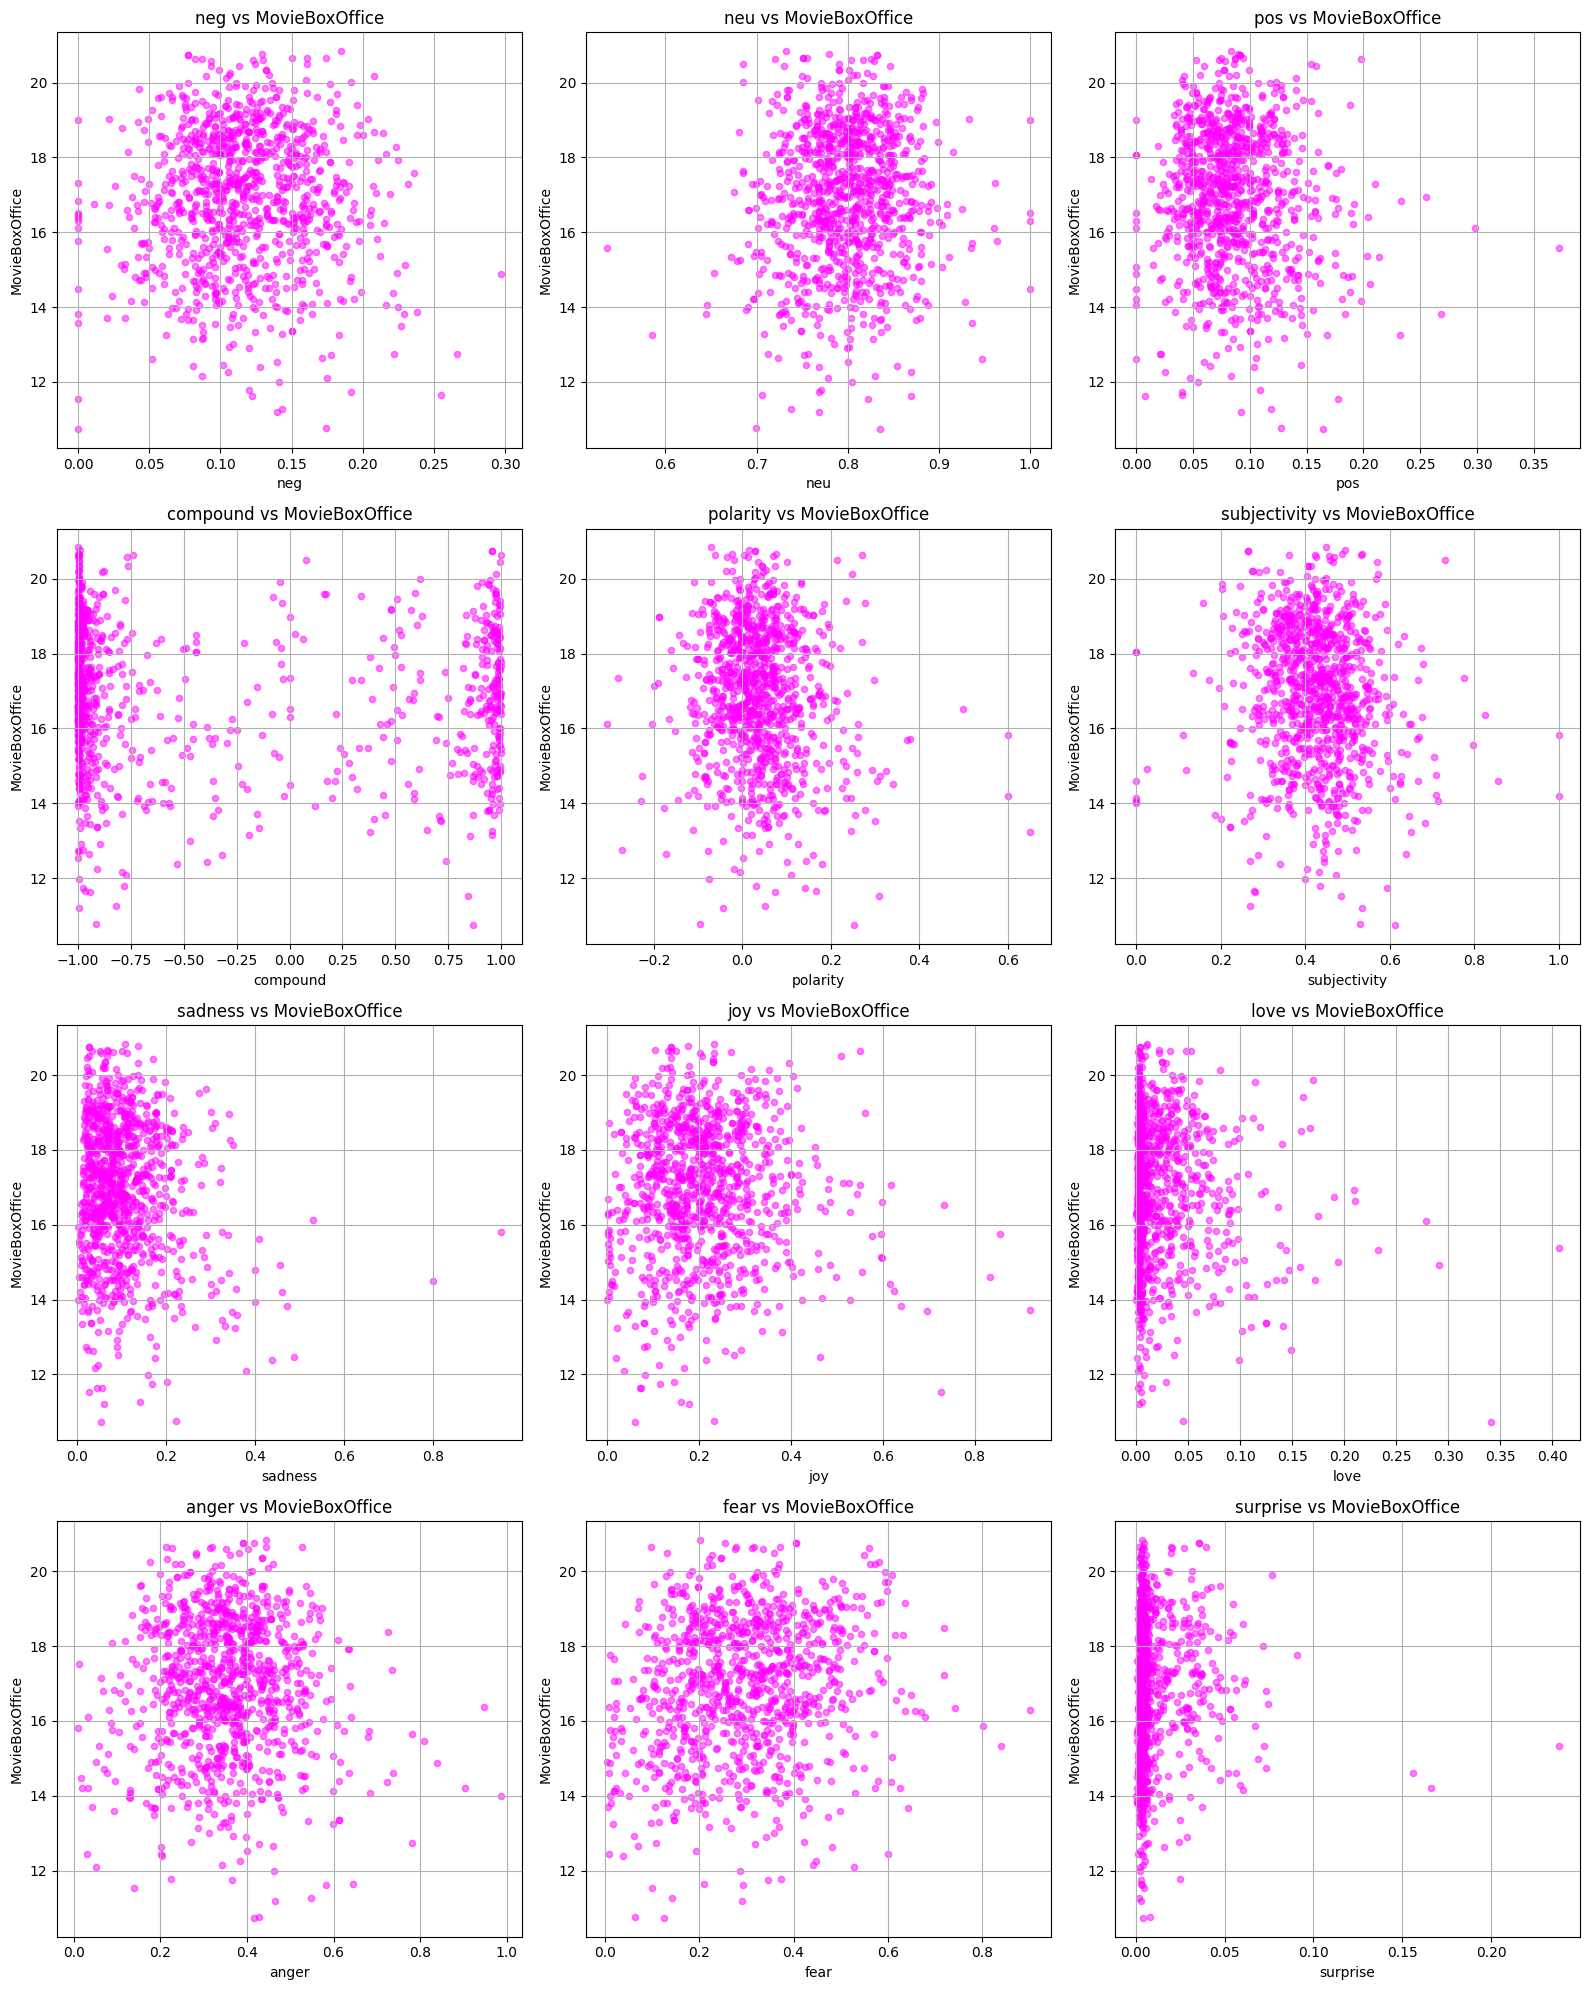

,MovieBoxOffice,MovieGenre,wikipedia_id,neg,neu,pos,compound,polarity,subjectivity,sadness,joy,love,anger,fear,surprise
0,17.727534,"Silent film, Indie, Costume drama, Epic, Black...",3333,0.091,0.813,0.096,0.827918,0.010443,0.373771,0.084214,0.199645,0.039794,0.396916,0.275427,0.004004
1,13.710150,"Silent film, Drama, Comedy, Black-and-white, F...",21135479,0.108,0.804,0.087,0.023440,0.020000,0.370000,0.024503,0.920107,0.004826,0.040952,0.006256,0.003356
2,12.523897,"Silent film, Drama, Black-and-white",73930,0.140,0.800,0.060,0.998401,0.000441,0.444182,0.090607,0.277512,0.036329,0.400345,0.192651,0.002556
3,14.508658,"Horror, Silent film, Drama",308930,0.102,0.796,0.102,0.315732,0.021553,0.426652,0.108809,0.197574,0.020602,0.308628,0.358939,0.005449
4,13.262125,"Romance Film, Adventure, War film",31667694,0.062,0.770,0.168,0.913362,0.245833,0.462500,0.263997,0.178680,0.110760,0.344264,0.098361,0.003938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,15.635381,"Thriller, Mystery, Romance Film",27504596,0.175,0.779,0.046,0.974169,-0.084091,0.222727,0.114257,0.168021,0.004135,0.373650,0.336715,0.003221
998,15.340243,"Drama, Japanese Movies, World cinema",30470501,0.180,0.784,0.036,0.902690,-0.086905,0.515476,0.023294,0.005013,0.000880,0.058644,0.840172,0.071998
999,16.574272,"Crime Fiction, Mystery, Thriller, Drama",32621340,0.144,0.805,0.051,0.953357,0.043713,0.421280,0.082206,0.071868,0.002804,0.314506,0.524668,0.003949
1000,16.599035,"Thriller, Mystery",35020822,0.107,0.872,0.021,0.944201,-0.043849,0.208135,0.069792,0.175348,0.004140,0.263263,0.482916,0.004542


In [ ]:
data = pd.read_csv('adapted_movies_sentiments.csv')
exploratory_plot(data, 'MovieBoxOffice')

### linear regression

In [25]:
results_boxoffice_adapted = train_linear_regression(data_adapted, 'MovieBoxOffice')
results_boxoffice_all = train_linear_regression(data_all, 'MovieBoxOffice')
results_log_boxoffice_adapted = train_linear_regression(data_adapted_log, 'MovieBoxOffice', log=True)
results_log_boxoffice_all = train_linear_regression(data_all_log, 'MovieBoxOffice', log=True)

results_rating_adapted = train_linear_regression(data_adapted, 'MovieRating')
results_rating_all = train_linear_regression(data_all, 'MovieRating')
results_log_rating_adapted = train_linear_regression(data_adapted_log, 'MovieRating', log=True)
results_log_rating_all = train_linear_regression(data_all_log, 'MovieRating', log=True)

                            OLS Regression Results                            
Dep. Variable:         MovieBoxOffice   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     7.218
Date:                Wed, 18 Dec 2024   Prob (F-statistic):           9.06e-13
Time:                        19:53:19   Log-Likelihood:                -2002.9
No. Observations:                1002   AIC:                             4032.
Df Residuals:                     989   BIC:                             4096.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      1.72e+05   3.65e+06      0.047   

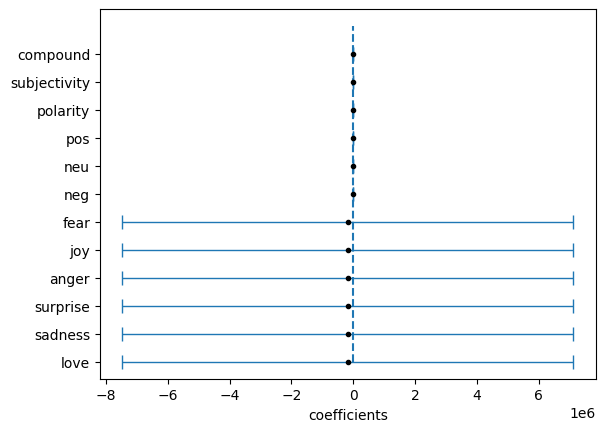

In [28]:
# use plotly to pick settings ! 
plot_coefficients(results)